# PSR J1023+0038 Light Curve
### Adam Mendoza

We will use the dataset obtained from the XMM-Newton Optical Monitor (OM) starting from `2017 June 9` at `22:32:27` until `2017 June 10` at `5:02:13`. The data measures optical brightness in the B filter band, which captures light around a central wavelength of $450\ \text{nm}$ in the blue region of the visible spectrum. The unit of flux that is used is $\text{mJy}$. The paper can be accessed [here](https://www.aanda.org/articles/aa/pdf/2019/11/aa36008-19.pdf).

In [1]:
# Import necessary packages

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error  
import pycwt as wavelet

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})

## Mean squared displacement (MSD)

We will define a function that calculates the MSD of a given arbitrary dataset. By definition,

$$\text{MSD}(\Delta)=\frac{1}{N-\Delta}\sum_{k=0}^{N-\Delta-1}\left({X(t_k+\Delta)-X(t_k)}\right)^2.$$

We will implement this function:

In [2]:
def msd_array(data):

    data = np.array(data)
    N = len(data)
    msd_vals = []

    for delta in range(1, N):
        msd_vals.append(np.mean([(data[k + delta] - data[k]) ** 2 for k in range(N - delta)]))

    return msd_vals[:int(len(msd_vals)/2)] #we will only take half of it 
                                           #since larger lag time = smaller samples = noisy


## Detrending functions

There are different ways on detrending datasets. The idea is we want to extract the trends of an arbitrary dataset so that the noise remains. First, we will define a function that takes the moving average of a dataset given a window.

In [3]:
def mov_ave(data, window):
    data = np.array(data)
    ave_trend = []
    window = int(window)

    for i in range(len(data)-2*window): 
        ave_trend.append(np.mean(data[i:i+2*window+1])) 
        #we want to take the average of the slice centered at i + window.
    
    return ave_trend 

# note that the moving average technique excludes the edges of the data, 
# leaving us with corresponding data[window:-window].

def mov_ave_detrend(data, window):

    data = np.array(data)
    window = int(window)
    trend = mov_ave(data, window) #we get the trend from the moving average method

    detrend = data[window:-window] - trend 
    #exclude the values not considered by mov_ave. subtract the mov_ave trend from the remaining data

    return detrend

We can also detrend using FFT. The idea here is that we want to exclude high frequency terms, making it 0, leaving us with low frequency values. Transforming it back to the original space will leave us with the detrended data.

In [4]:
def fft_detrend(data, n_discard):
    
    fft = np.fft.rfft(data)  # take the data of the fft

    largest_indices = np.argsort(np.abs(fft))[-int(n_discard):] #take indices of n highest values 
    detrend = np.copy(fft)
    detrend[largest_indices] = 0 #make n highest values 0

    detrend_fft = np.fft.irfft(detrend) 
    
    return detrend_fft

## Application: Random Walk

We will simulate a random walk.

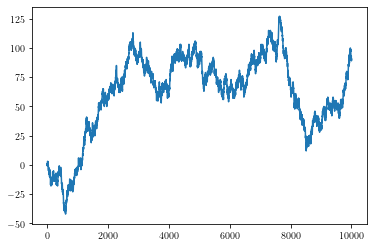

In [5]:
np.random.seed(30)

n_points = 10**4 # initiate number of steps
rand_walk = [0] # initial position

for i in range(n_points):
    val = np.random.rand()
    if val < 0.5: #we want 0.5 since we want left and right steps to be equally likely
        rand_walk.append(-1 + rand_walk[i])
    else:
        rand_walk.append(1 + rand_walk[i])

plt.plot(rand_walk)
plt.show()

We will detrend this. It is more appropriate to use the method of moving averages with a window of 100. The trend looks like:

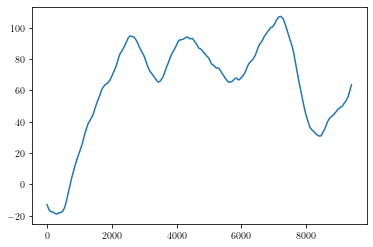

In [6]:
rw_window = 300

rw_trend = mov_ave(rand_walk, rw_window)
plt.plot(rw_trend)
plt.show()

Detrending, the plot now looks like this:

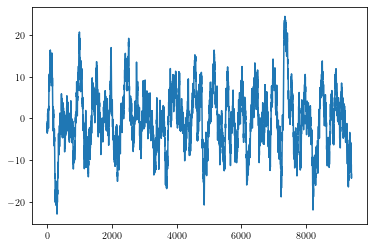

In [7]:
rw_detrend = mov_ave_detrend(rand_walk, rw_window)
plt.plot(rw_detrend)
plt.show()

Now that we have detrended it, we will look at the distribution of the noise through the histogram. We will use the Terrell-Scott rule for the number of bins, saying that the optimal number must be $(2n)^{1/3}$.

In [8]:
def tscott_bins(data):
    return int((2*len(rw_detrend))**(1/3))

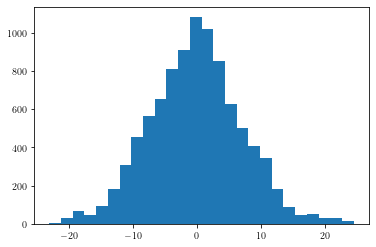

In [9]:
plt.hist(rw_detrend, bins = tscott_bins(rw_detrend))
plt.show()

We can see that it is normally distributed. Next, we can check for the MSD plot.

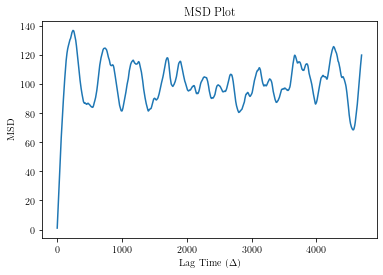

In [10]:
plt.title('$\mathrm{MSD\ Plot}$')
plt.xlabel('$\mathrm{Lag\ Time}\ (\Delta)$')
plt.ylabel('$\mathrm{MSD}$')
plt.plot(msd_array(rw_detrend))
plt.show()

## MSD for data with uneven time steps

We cannot use the regular MSD algorithm for some data that contains gaps. This results to uneven time steps in the gap regions. What we want to do is to take all possible pair of points and take their squared difference, define logarithmically spaced time bins, find the corresponding squared values within the bin, and take its mean. This will be our MSD.

In [11]:
#define a function that inputs the data and its corresponding time array 
#and outputs time bins and their corresponding msd values.

def binned_msd(data, time, n_bins = None):

    if n_bins == None:
        n_bins = 100
    else:
        n_bins = int(n_bins)
        
    data = np.array(data)
    time = np.array(time)
    
    lag_times = []
    sq_diff = []

    for i in range(len(data)):
        for j in range(i+1, len(data)): 
            delta_t = time[j] - time[i] #take all possible pair of time points 
            squared_diff = (data[j] - data[i]) ** 2  #take their squared difference
            lag_times.append(delta_t)
            sq_diff.append(squared_diff)

    lag_times = np.array(lag_times)
    sq_diff = np.array(sq_diff)
    
    # define log lag time bins. make logarithmically spaced bins.
    log_min = np.log10(np.min(lag_times)) #ensure that the first logspace array val is np.min(lag_times)
    log_max = np.log10(np.max(lag_times)) #ensure that the last logspace array val is np.max(lag_times)
    bins = np.logspace(log_min, log_max, num=n_bins)

    msd_vals = []
    bin_centers = []
    msd_errors = []
    
    for k in range(len(bins)-1):
        bin_mask = (lag_times >= bins[k]) & (lag_times < bins[k+1]) 
        #make a boolean mask from the lag times
        if np.sum(bin_mask) > 0:
            bin_sq_diff = sq_diff[bin_mask]
            #get square differences that fall into the mask
            msd_vals.append(np.mean(bin_sq_diff)) 
            #calculate mean squared difference of sq_diff values falling to the mask
            bin_centers.append((bins[k] + bins[k+1])/2) 
            #take bin centers

            RMS = np.sqrt(np.mean((bin_sq_diff - np.mean(bin_sq_diff)) ** 2))
            msd_error = RMS / np.sqrt(np.sum(bin_mask))
            msd_errors.append(msd_error)

    msd_vals = np.abs(np.array(msd_vals))
    bin_centers = np.abs(np.array(bin_centers))
    msd_errors = np.abs(np.array(msd_errors))        
    
    return bin_centers[:int(len(bin_centers)/2)], msd_vals[:int(len(msd_vals)/2)], msd_errors[:int(len(msd_vals)/2)] #just take half 

## PSR J1023+0038

We will now apply the functions and techniques in our pulsar data. 

In [12]:
#Initiate the data

b_band = pd.read_csv("..//datasets//PSR_J1023-2019/BBand.csv")
b_band.head()

,Time,Flux,e_Flux
0,-5253.208496,0.549461,0.095646
1,-5243.208496,0.630092,0.099528
2,-5233.208496,0.445528,0.091511
3,-5223.208496,0.629439,0.099528
4,-5213.208496,0.698945,0.103198


The plot looks like this:

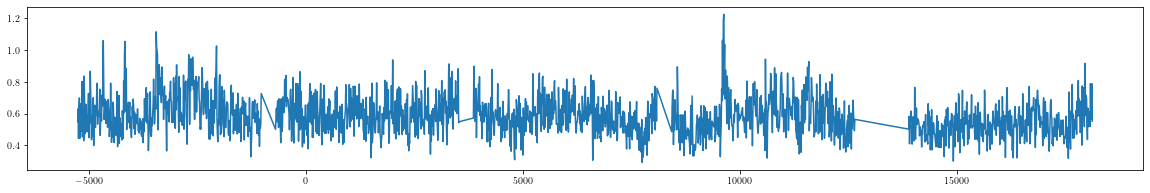

In [13]:
plt.figure(figsize=(20,3))
plt.plot(b_band.Time, b_band.Flux)
plt.show()

There are gaps in the data that are probably null. For now, we will ignore these gaps (not really sure if this is a good idea) and attach the pieces together. We will now plot the flux curve and its detrended counterpart.

In [14]:
flux = b_band.Flux

movave_window = 50
fft_thresh = 6
movave_flux = mov_ave_detrend(flux, movave_window)
fft_flux = fft_detrend(flux, fft_thresh)

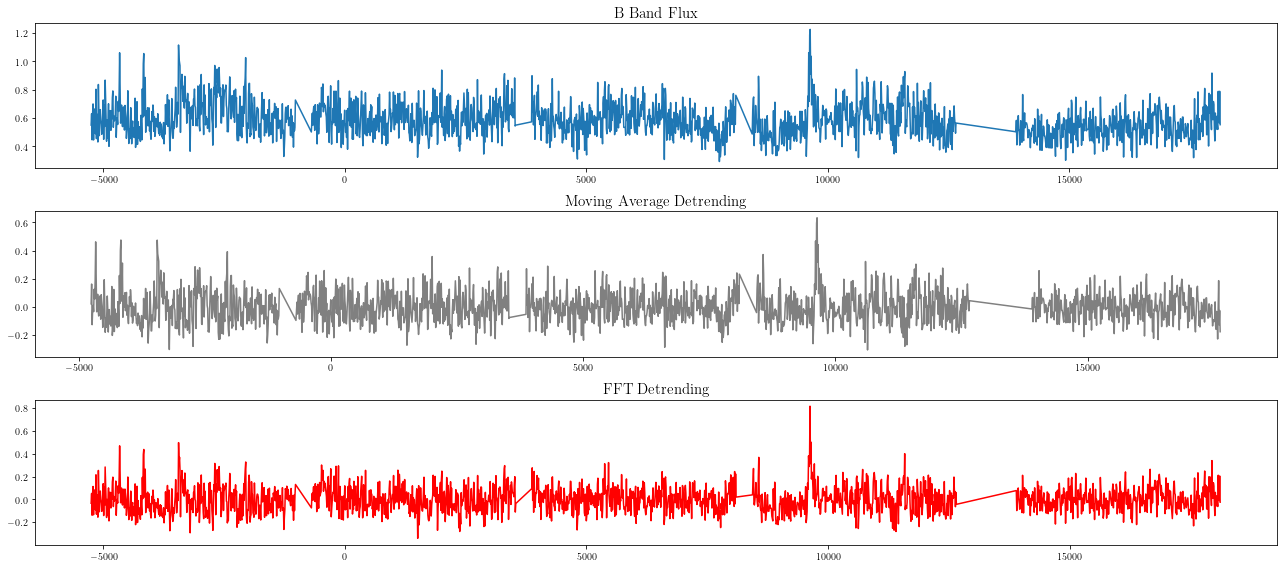

In [15]:
plt.figure(figsize=(18,8))

plt.subplot(3,1,1)
plt.title('$\mathrm{B\ Band\ Flux}$', fontsize = 15)
plt.plot(b_band.Time, flux)

plt.subplot(3,1,2)
plt.title('$\mathrm{Moving\ Average\ Detrending}$', fontsize = 15)
plt.plot(b_band.Time[movave_window:-movave_window], movave_flux, c = 'gray')

plt.subplot(3,1,3)
plt.title('$\mathrm{FFT\ Detrending}$', fontsize = 15)
plt.plot(b_band.Time[:-1], fft_flux, c = 'red')

plt.tight_layout()
plt.savefig('..//figures//PSR_J1023//detrending_mod.png', dpi = 300, bbox_inches = 'tight')
plt.show()

We can check the distribution of our detrended data.

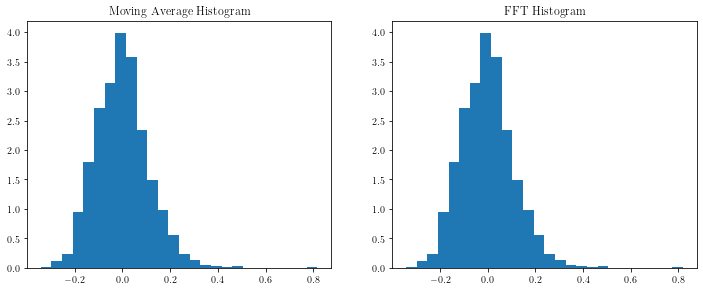

In [16]:
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
plt.hist(fft_flux, bins = tscott_bins(fft_flux), density= True)
plt.title('$\mathrm{Moving\ Average\ Histogram}$')

plt.subplot(2,2,2)
plt.hist(fft_flux, bins = tscott_bins(fft_flux), density= True)
plt.title('$\mathrm{FFT\ Histogram}$')

plt.savefig('..//figures//PSR_J1023//detrend_hist_mod.png', dpi = 500, bbox_inches = 'tight')
plt.show()

Both detrending methods yield a Gaussian distribution. We will calculate the MSD resulting from these detrending but we will use the MSD function with uneven time steps since we have gaps.

In [17]:
bins_val = 1500

bin_cent_movave, msd_movave, msd_err_movave = binned_msd(movave_flux, b_band.Time[movave_window:-movave_window], n_bins = bins_val)
bin_cent_fft, msd_fft, msd_err_fft = binned_msd(fft_flux, b_band.Time[:-1], n_bins = bins_val)

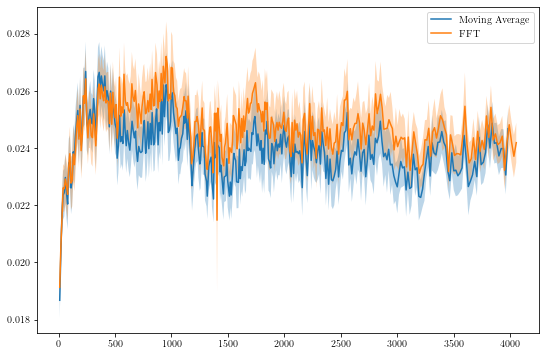

In [18]:
plt.figure(figsize=(9, 6))

plt.plot(bin_cent_movave, msd_movave, label = '$\mathrm{Moving\ Average}$')
plt.fill_between(bin_cent_movave, msd_movave - msd_err_movave, msd_movave + msd_err_movave, alpha=0.3)

plt.plot(bin_cent_fft, msd_fft, label = '$\mathrm{FFT}$')
plt.fill_between(bin_cent_fft, msd_fft - msd_err_fft, msd_fft + msd_err_fft, alpha=0.3)

plt.legend()
plt.savefig('..//figures//PSR_J1023//raw_msd_mod.png', dpi = 300, bbox_inches = 'tight')
plt.show()

Consider the memory function

$$f(t-t')=(t-t'+\tau)^{(\mu-1)/2}$$

with a window function

$$h(t')=\frac{e^{-\beta/t'}}{{t'}^{(\mu+1)/2}}.$$

Our theoretical MSD formula is given by:

$$\text{MSD}_{\text{theo}}(t)\ =\ \int_0^t (t-t'+\tau)^{(\mu-1)/2}\frac{e^{-\beta/t'}}{{t'}^{(\mu+1)/2}}\,\mathrm{d}t\ =\ \Gamma(\mu)(t+\tau)^{\mu-1}\beta^{-\mu}e^{-\beta/(t+\tau)}.$$

Note that the original memory function does not have the delay parameter $\tau$. I have included it so that we have more knobs to turn to get a better fit. After all, this only corresponds to a shift $t\to t+\tau$ in the MSD. Now, we want to find the values of $\mu$, $\beta$, and $\tau$ that fits best to the MSD we have obtained from the data. This can be done by finding the combinations of the parameters that produces the lowest error. First take the moving average detrending.

In [19]:
# theoretical MSD function
def msd_theo(t, mu, beta, tau):
    return sp.special.gamma(mu) * (t+tau)**(mu - 1) * beta**(-mu) * np.exp(-beta / (t+tau))

def msd_theo_movave(t, mu, beta, tau):
    msd_theo_vals = msd_theo(t, mu, beta, tau)
    # Align the first value of the theoretical MSD with the first value of the experimental MSD
    # msd_theo_vals += msd_movave[0] - msd_theo_vals[0]
    return msd_theo_vals

opt_params, cov_matrix = sp.optimize.curve_fit(msd_theo_movave, bin_cent_movave, msd_movave, sigma= msd_err_movave, absolute_sigma=False,  bounds=([10**-3, 10**-3, 10**-3], [2.0, 200, 200]))

# Extract the standard deviations (errors) for each fitted parameter
param_errors = np.sqrt(np.diag(cov_matrix))

mu_opt, beta_opt, tau_opt = opt_params
mu_err, beta_err, tau_err = param_errors

print('The optimal parameters are (mu, beta, tau) = ({:.7f} \u00B1 {:.3f}, {:.3f} \u00B1 {:.3f}, {:.3f} \u00B1 {:.3f})'.format(mu_opt,mu_err,beta_opt,beta_err,tau_opt,tau_err))

The optimal parameters are (mu, beta, tau) = (0.9379135 ± 0.002, 33.111 ± 0.247, 69.190 ± 5.070)


We will now apply these optimal parameters.

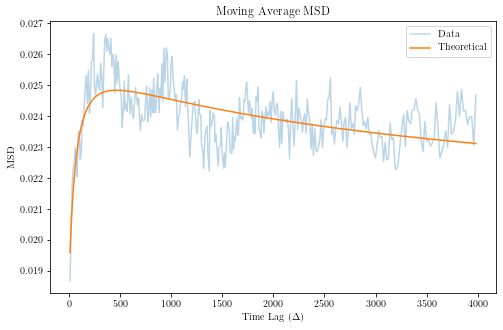

In [20]:
mu_opt, beta_opt, tau_opt = opt_params
msd_theo_array = msd_theo_movave(bin_cent_movave, mu_opt, beta_opt, tau_opt)

# make the first values of both arrays equal
# msd_theo_array += msd_movave[0] - msd_theo_array[0]

plt.figure(figsize=(8, 5))
plt.plot(bin_cent_movave, msd_movave, alpha=0.3, label = '$\mathrm{Data}$')
plt.plot(bin_cent_movave, msd_theo_array, label = '$\mathrm{Theoretical}$')

plt.title('$\mathrm{Moving\ Average\ MSD}$')
plt.xlabel('$\mathrm{Time\ Lag}\ (\Delta)$')
plt.ylabel('$\mathrm{MSD}$')
plt.legend()

plt.savefig('..//figures//PSR_J1023//movave_msd_mod.png', dpi = 300, bbox_inches = 'tight')
plt.show()

For the FFT detrending:

In [21]:
# theoretical MSD function
def msd_theo(t, mu, beta, tau):
    return sp.special.gamma(mu) * (t+tau)**(mu - 1) * beta**(-mu) * np.exp(-beta / (t+tau))

def msd_theo_fft(t, mu, beta, tau):
    msd_theo_vals = msd_theo(t, mu, beta, tau)
    # msd_theo_vals += msd_fft[0] - msd_theo_vals[0]
    return msd_theo_vals

opt_params, cov_matrix = sp.optimize.curve_fit(msd_theo_fft, bin_cent_fft, msd_fft, sigma= msd_err_fft, bounds=([10**-3, 10**-3, 10**-3], [2.0, 100, 100]) )

# extract errors for each fitted parameter
param_errors = np.sqrt(np.diag(cov_matrix))

mu_opt, beta_opt, tau_opt = opt_params
mu_err, beta_err, tau_err = param_errors
print('The optimal parameters are (mu, beta, tau) = ({:.7f} \u00B1 {:.3f}, {:.3f} \u00B1 {:.3f}, {:.3f} \u00B1 {:.3f})'.format(mu_opt,mu_err,beta_opt,beta_err,tau_opt,tau_err))

The optimal parameters are (mu, beta, tau) = (0.9468029 ± 0.002, 33.025 ± 0.207, 68.146 ± 4.025)


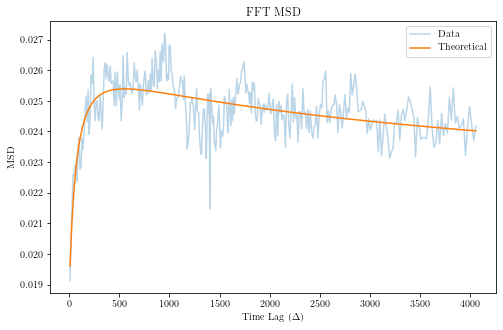

In [22]:
msd_theo_array = msd_theo_fft(bin_cent_fft, mu_opt, beta_opt, tau_opt)

plt.figure(figsize=(8, 5))
plt.plot(bin_cent_fft, msd_fft, alpha=0.3, label = '$\mathrm{Data}$')
plt.plot(bin_cent_fft, msd_theo_array, label = '$\mathrm{Theoretical}$')

plt.title('$\mathrm{FFT\ MSD}$')
plt.xlabel('$\mathrm{Time\ Lag}\ (\Delta)$')
plt.ylabel('$\mathrm{MSD}$')
plt.legend()

plt.savefig('..//figures//PSR_J1023//fft_msd_mod.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Influences on the $\mu$ parameter

Here, we aim to uncover how the strictness of detrending affects the memory parameter $\mu$.

In [23]:
bins_val = 1000
win_vals = [*range(5,105,5)]
mu_vals = []
mu_err_vals = []
beta_vals = []
for movave_window in win_vals:

    movave_flux = mov_ave_detrend(flux, movave_window)
    bin_cent_movave, msd_movave, msd_err_movave = binned_msd(movave_flux, b_band.Time[movave_window:-movave_window], n_bins = bins_val)

    def msd_theo_movave(t, mu, beta, tau):
        msd_theo_vals = msd_theo(t, mu, beta, tau)
        # align the first value of the theoretical MSD with the first value of the experimental MSD
        # msd_theo_vals += msd_movave[0] - msd_theo_vals[0]
        return msd_theo_vals

    opt_params, cov_matrix = sp.optimize.curve_fit(msd_theo_movave, bin_cent_movave, msd_movave, sigma= msd_err_movave, absolute_sigma=False,  bounds=([10**-3, 10**-3, 10**-3], [2.0, 100, 100]))

    # Extract the standard deviations (errors) for each fitted parameter
    param_errors = np.sqrt(np.diag(cov_matrix))

    mu_opt, beta_opt, tau_opt = opt_params
    mu_err, beta_err, tau_err = param_errors
    mu_vals.append(mu_opt)
    beta_vals.append(beta_opt)
    mu_err_vals.append(mu_err)

mu_vals = np.array(mu_vals)
beta_vals = np.array(beta_vals)

In [24]:
mu_vals = np.array(mu_vals)
mu_err_vals = np.array(mu_err_vals)

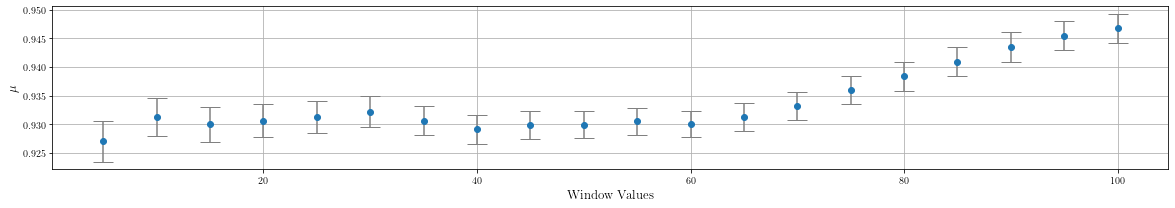

In [25]:
plt.figure(figsize = (20,3))
plt.errorbar(win_vals, mu_vals, yerr=mu_err_vals, fmt='o', ecolor='gray', capsize=10)
plt.xlabel('$\mathrm{Window\ Values}$', fontsize = 13)
plt.ylabel('$\mu$', fontsize = 13)
plt.grid(True)


plt.savefig('..//figures//PSR_J1023//mu_wind_mod.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [26]:
bins_val = 1000
thresh_vals = [*range(1,21,1)]
mu_vals_fft = []
mu_err_vals_fft = []

for thresh in thresh_vals:
    fft_flux = fft_detrend(flux, thresh)
    bin_cent_fft, msd_fft, msd_err_fft = binned_msd(fft_flux, b_band.Time[:-1], n_bins = bins_val)

    def msd_theo_fft(t, mu, beta, tau):
        msd_theo_vals = msd_theo(t, mu, beta, tau)
        # msd_theo_vals += msd_fft[0] - msd_theo_vals[0]
        return msd_theo_vals

    opt_params, cov_matrix = sp.optimize.curve_fit(msd_theo_fft, bin_cent_fft, msd_fft, sigma= msd_err_fft, bounds=([10**-3, 10**-3, 10**-3], [2.0, 100, 100]) )

    param_errors = np.sqrt(np.diag(cov_matrix))

    mu_opt_fft, beta_opt, tau_opt = opt_params
    mu_err_fft, beta_err, tau_err = param_errors
    mu_vals_fft.append(mu_opt_fft)
    mu_err_vals_fft.append(mu_err_fft)

mu_vals_fft = np.array(mu_vals_fft)
mu_err_vals_fft = np.array(mu_err_vals_fft)

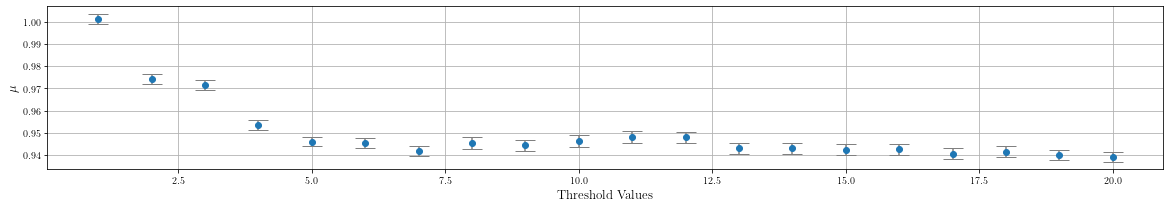

In [27]:
plt.figure(figsize = (20,3))
plt.errorbar(thresh_vals, mu_vals_fft, yerr=mu_err_vals_fft, fmt='o', ecolor='gray', capsize=10)
# plt.fill_between(thresh_vals, mu_vals_fft-mu_err_vals_fft, mu_vals_fft+mu_err_vals_fft, alpha = 0.3)
plt.xlabel('$\mathrm{Threshold\ Values}$', fontsize = 13)
plt.ylabel('$\mu$', fontsize = 13)
plt.grid(True)

plt.savefig('..//figures//PSR_J1023//mu_thresh_mod.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Raw data

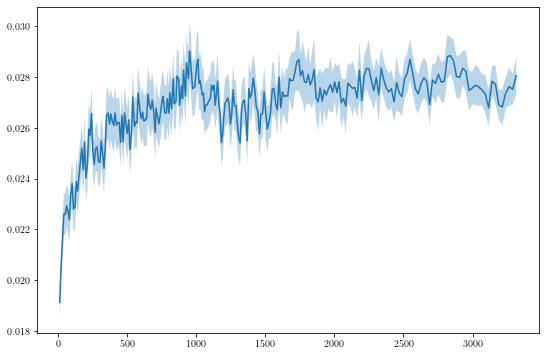

In [28]:
plt.figure(figsize=(9, 6))

bin_cent_raw, msd_raw, msd_err_raw = binned_msd(b_band.Flux, b_band.Time, n_bins = 1000)

plt.plot(bin_cent_raw, msd_raw)
plt.fill_between(bin_cent_raw, msd_raw - msd_err_raw, msd_raw + msd_err_raw, alpha=0.3)

plt.savefig('..//figures//PSR_J1023//raw_msd_err.png', dpi = 300, bbox_inches = 'tight')
plt.show()

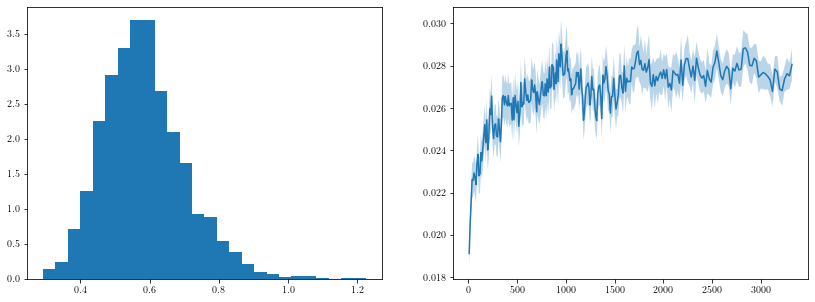

In [29]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(b_band.Flux, tscott_bins(b_band.Flux), density=True)

plt.subplot(1,2,2)
plt.plot(bin_cent_raw, msd_raw)
plt.fill_between(bin_cent_raw, msd_raw - msd_err_raw, msd_raw + msd_err_raw, alpha=0.3)

plt.savefig('..//figures//PSR_J1023//raw_hist_msd.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [30]:
def msd_theo_raw(t, mu, beta, tau):
    msd_theo_vals = msd_theo(t, mu, beta, tau)
    # msd_theo_vals += msd_raw[0] - msd_theo_vals[0]
    return msd_theo_vals

opt_params, cov_matrix = sp.optimize.curve_fit(msd_theo_raw, bin_cent_raw, msd_raw, sigma = msd_err_raw, bounds=([10**-3, 10**-3, 10**-3], [2.0, 100, 100]) )

# extract errors for each fitted parameter
param_errors = np.sqrt(np.diag(cov_matrix))

mu_opt, beta_opt, tau_opt = opt_params
mu_err, beta_err, tau_err = param_errors

print('The optimal parameters are (mu, beta, tau) = ({:.7f} \u00B1 {:.3f}, {:.3f} \u00B1 {:.3f}, {:.3f} \u00B1 {:.3f})'.format(mu_opt,mu_err,beta_opt,beta_err,tau_opt,tau_err))

The optimal parameters are (mu, beta, tau) = (1.0014158 ± 0.002, 35.922 ± 0.270, 99.174 ± 6.055)


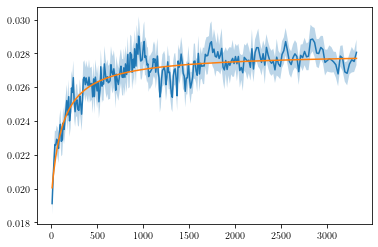

In [31]:
plt.plot(bin_cent_raw, msd_raw)
plt.fill_between(bin_cent_raw, msd_raw - msd_err_raw, msd_raw + msd_err_raw, alpha=0.3)
plt.plot(bin_cent_raw, msd_theo_raw(bin_cent_raw, mu_opt, beta_opt, tau_opt))
plt.show()

## Wavelet Transform

We will do a different type of detrending, one that is sensitive to small and large scale variations. This is the wavelet transform. We will use the Morlet wavelength for this. Let `dt` be the sampling interval, `dj` the spacing between scales, `s0` the smallest scale, and `J` the number of scales.

In [32]:
def wavelet_detrend(data, dt=1, dj=1, s0=2, J=7):

    # standardize data
    std = data.std()
    data_norm = (data - data.mean()) / std

    # define the Morlet wavelet and scales
    mother = wavelet.Morlet(6)  # ω0=6, typical for the Morlet wavelet
    s0 = s0 * dt  # Start scale based on the given dt
    wave, scales, _, _, _, _ = wavelet.cwt(data_norm, dt, dj, s0, J, mother)

    # perform inverse transform to get trend
    trend = wavelet.icwt(wave, scales, dt, dj, mother) * std + data.mean()

    # detrend data by subtracting the trend
    detrended_data = data - trend

    detrended_data = np.array(detrended_data)
    trend = np.array(trend)

    return detrended_data, trend

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


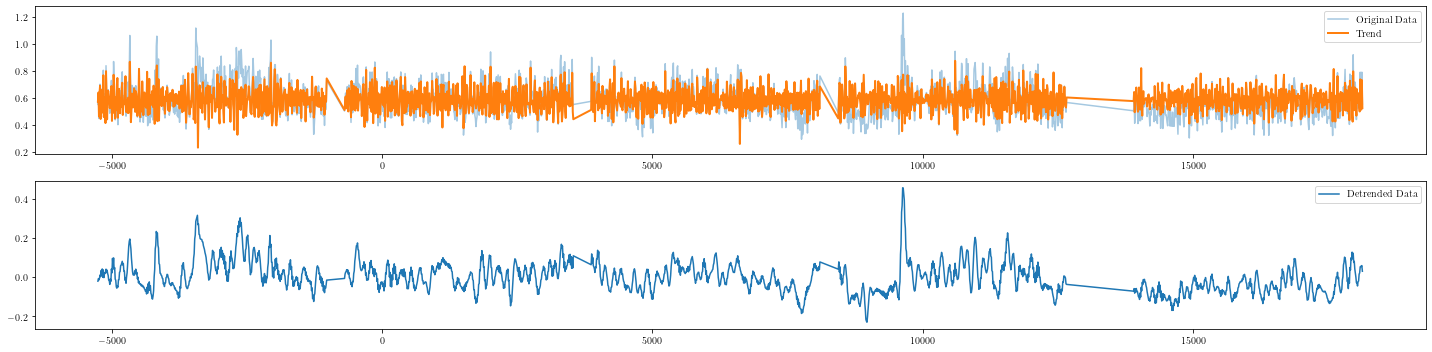

In [33]:
detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=0.3, s0=2, J=7)

plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.plot(b_band.Time, flux, label="$\mathrm{Original\ Data}$", alpha=0.4)
plt.plot(b_band.Time, flux_trend, label="$\mathrm{Trend}$", linewidth=2)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(b_band.Time, detrended_flux, label="$\mathrm{Detrended\ Data}$")
plt.legend()
plt.tight_layout()
plt.show()

We will now look at the how the detrended data changes with variations on different parameters.

### Variations in $\Delta j$

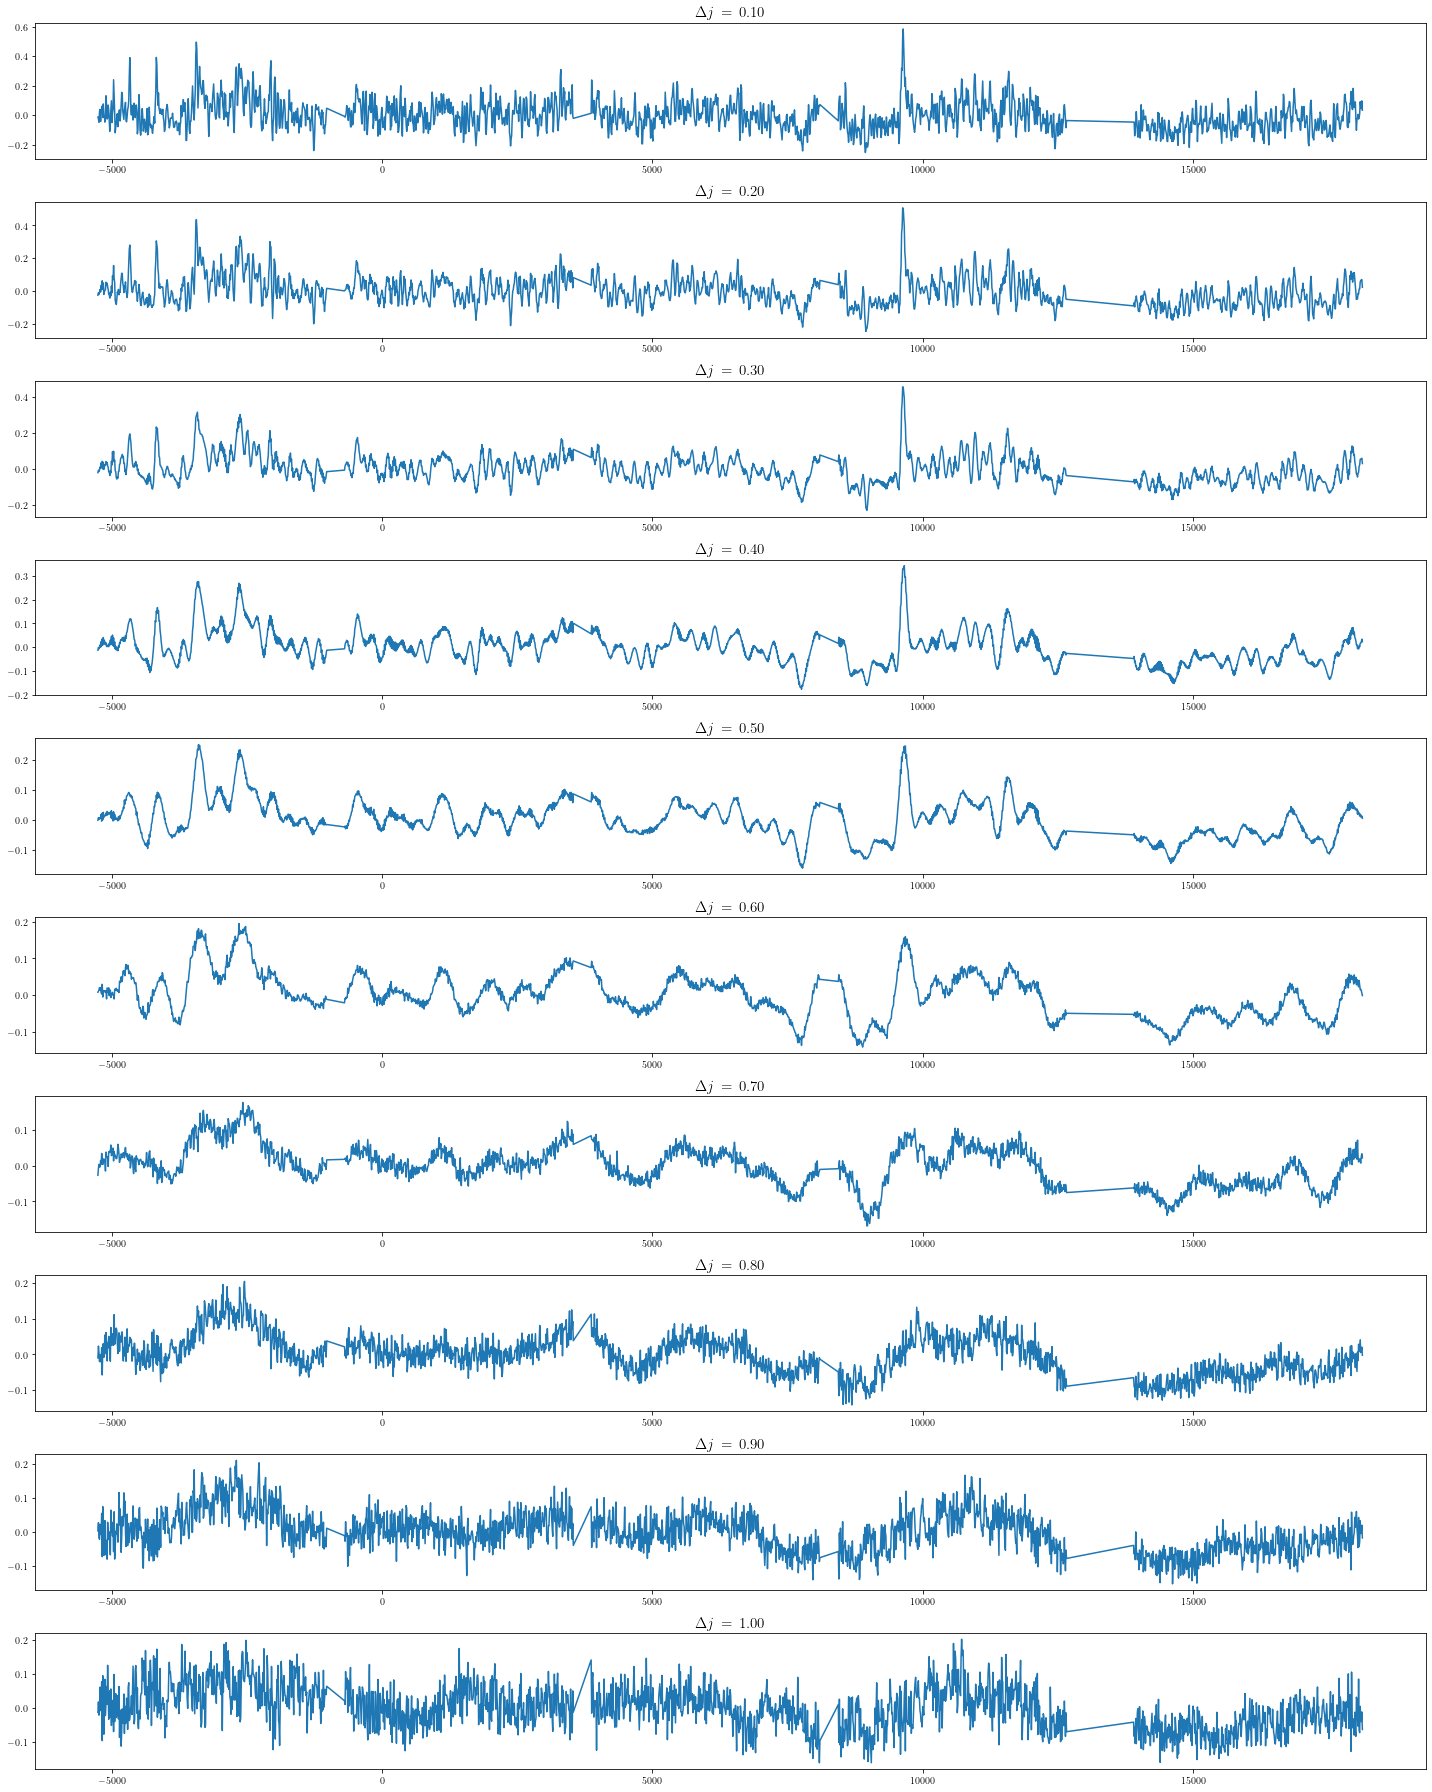

In [34]:
dj_vals = np.linspace(0.1, 1, 10)
plt.figure(figsize=(20,25))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=dj_vals[i], s0=2, J=7)
    plt.subplot(10, 1, i+1)
    plt.title('$\Delta j\,=\,{:.2f}$'.format(dj_vals[i]), fontsize = 15)
    plt.plot(b_band.Time, detrended_flux)

plt.tight_layout()
plt.show()
    

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\axes\_axes.py:6865: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


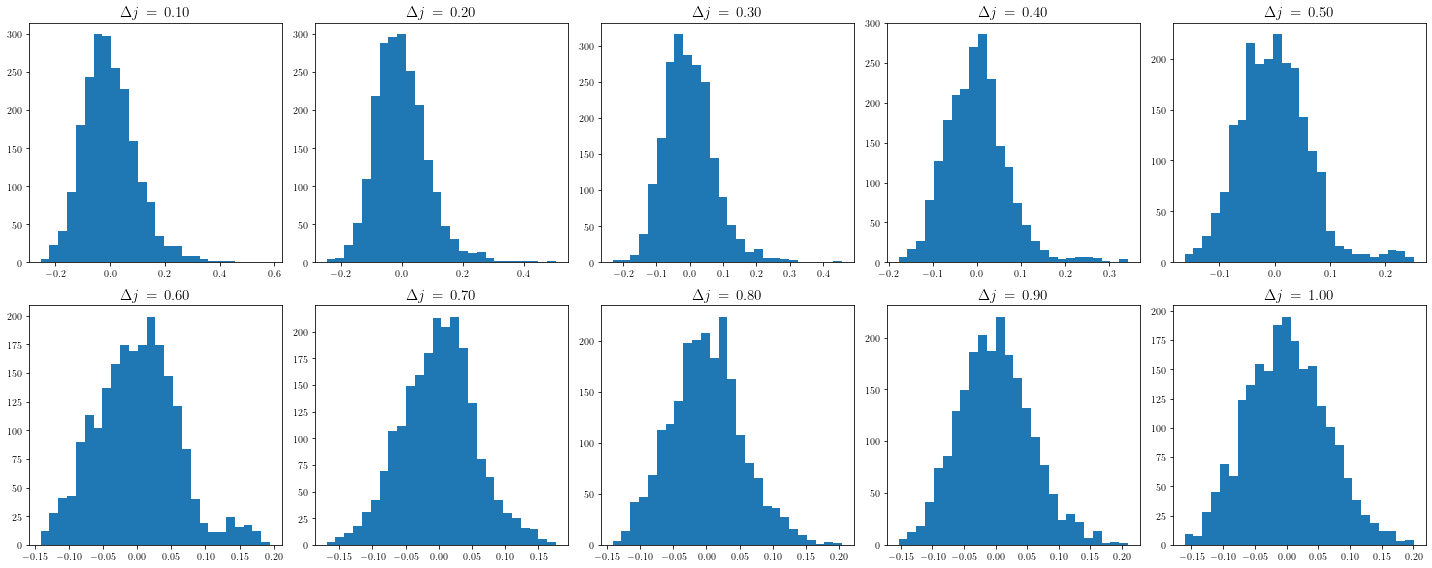

In [35]:
plt.figure(figsize=(20,8))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=dj_vals[i], s0=2, J=7)

    plt.subplot(2, 5, i+1)
    plt.title('$\Delta j\,=\,{:.2f}$'.format(dj_vals[i]), fontsize = 15)
    plt.hist(detrended_flux, tscott_bins(detrended_flux))

plt.tight_layout()
plt.show()

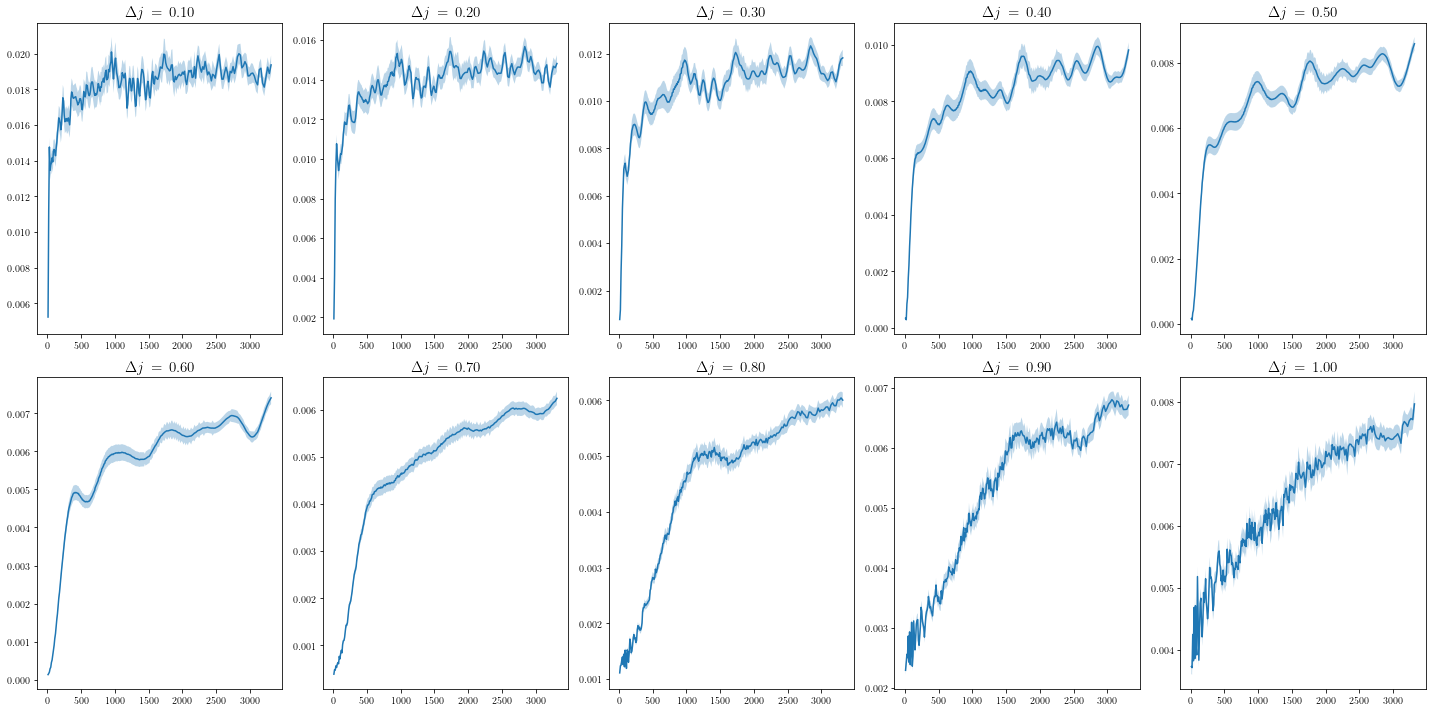

In [36]:
plt.figure(figsize=(20,10))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=dj_vals[i], s0=2, J=7)
    bin_cent_wav, msd_wav, msd_err_wav = binned_msd(detrended_flux, b_band.Time, n_bins = 1000)

    plt.subplot(2, 5, i+1)
    plt.title('$\Delta j\,=\,{:.2f}$'.format(dj_vals[i]), fontsize = 15)
    plt.plot(bin_cent_wav, msd_wav)
    plt.fill_between(bin_cent_wav, msd_wav - msd_err_wav, msd_wav + msd_err_wav, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
dj_vals = np.linspace(0.1, 1, 19)

mu_vals = []
mu_err_vals = []
beta_vals = []
tau_vals = []

for dj in dj_vals:
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=dj, s0=2, J=7)
    bin_cent_wav, msd_wav, msd_err_wav = binned_msd(detrended_flux, b_band.Time, n_bins = 1000)

    def msd_theo_wavelet(t, mu, beta, tau):
        msd_theo_vals = msd_theo(t, mu, beta, tau)
        # msd_theo_vals += msd_wav[0] - msd_theo_vals[0]  
        return msd_theo_vals

    opt_params, cov_matrix = sp.optimize.curve_fit(
        msd_theo_wavelet,
        bin_cent_wav,
        msd_wav,
        sigma=msd_err_wav,
        absolute_sigma=False,
        bounds=([1e-3, 1e-3, 1e-3], [2.0, 200, 300])
    )

    param_errors = np.sqrt(np.diag(cov_matrix))
    mu_opt, beta_opt, tau_opt = opt_params
    mu_err, beta_err, tau_err = param_errors

    mu_vals.append(mu_opt)
    beta_vals.append(beta_opt)
    tau_vals.append(tau_opt)
    mu_err_vals.append(mu_err)

mu_vals = np.array(mu_vals)
beta_vals = np.array(beta_vals)
mu_err_vals = np.array(mu_err_vals)
tau_vals = np.array(tau_vals)

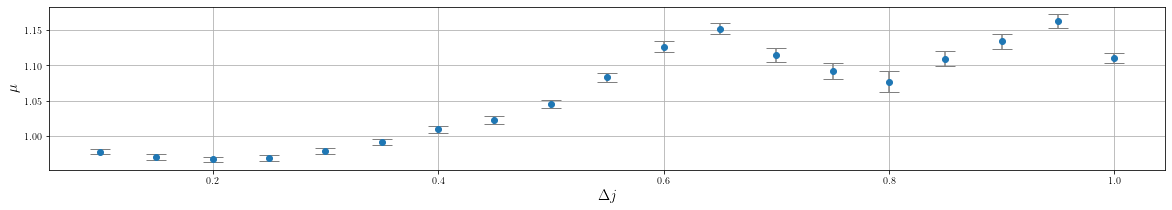

In [38]:
plt.figure(figsize = (20,3))
plt.errorbar(dj_vals, mu_vals, yerr=mu_err_vals, fmt='o', ecolor='gray', capsize=10)
plt.plot()
plt.xlabel('$\Delta j$', fontsize = 15)
plt.ylabel('$\mu$', fontsize = 15)
plt.grid(True)
plt.show()

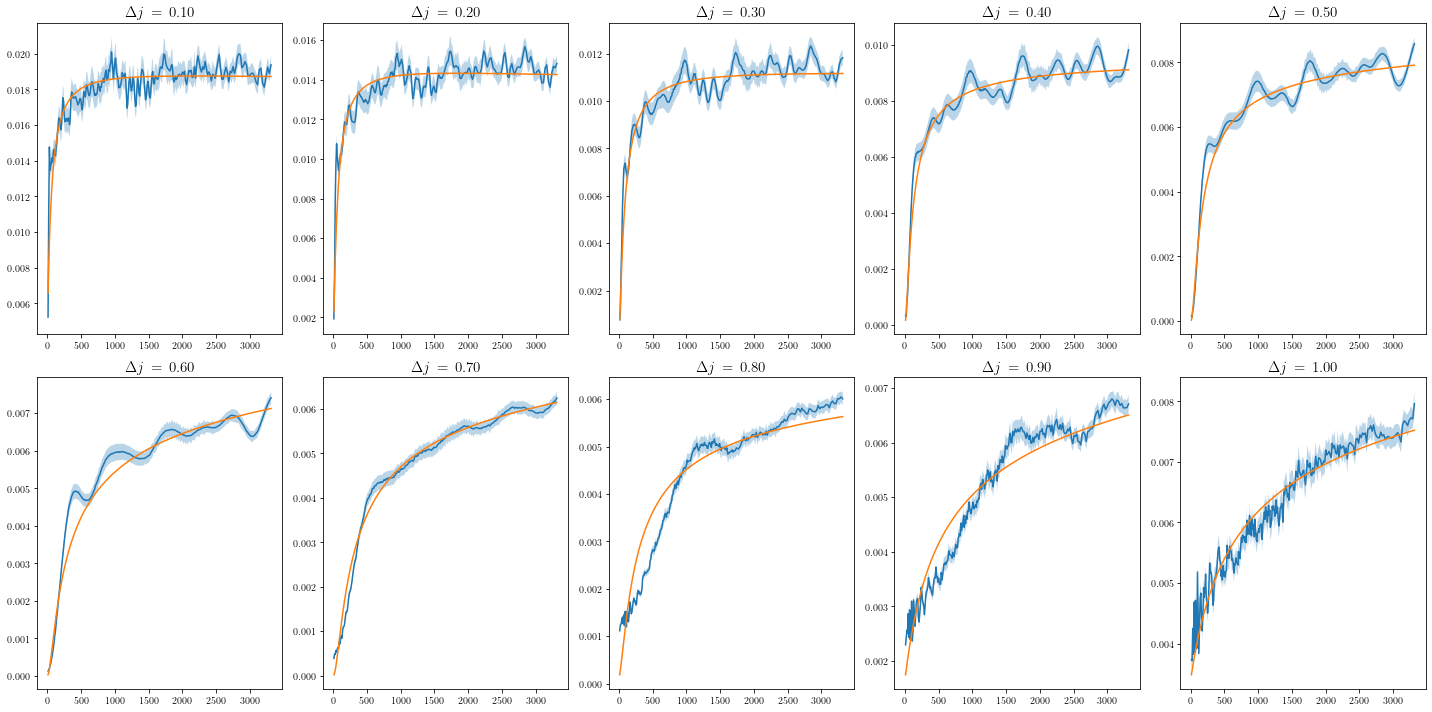

In [39]:
plt.figure(figsize=(20,10))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=dj_vals[2*i], s0=2, J=7)
    bin_cent_wav, msd_wav, msd_err_wav = binned_msd(detrended_flux, b_band.Time, n_bins = 1000)

    def msd_theo_wavelet(t, mu, beta, tau):
        msd_theo_vals = msd_theo(t, mu, beta, tau)
        # msd_theo_vals += abs(msd_wav[0]) - msd_theo_vals[0]  
        return msd_theo_vals

    plt.subplot(2, 5, i+1)
    plt.title('$\Delta j\,=\,{:.2f}$'.format(dj_vals[2*i]), fontsize = 15)
    plt.plot(bin_cent_wav, msd_wav)
    plt.fill_between(bin_cent_wav, msd_wav - msd_err_wav, msd_wav + msd_err_wav, alpha=0.3)
    plt.plot(bin_cent_wav, msd_theo_wavelet(bin_cent_wav, mu_vals[2*i], beta_vals[2*i], tau_vals[2*i]))

plt.tight_layout()
plt.show()

### Variations in $s$

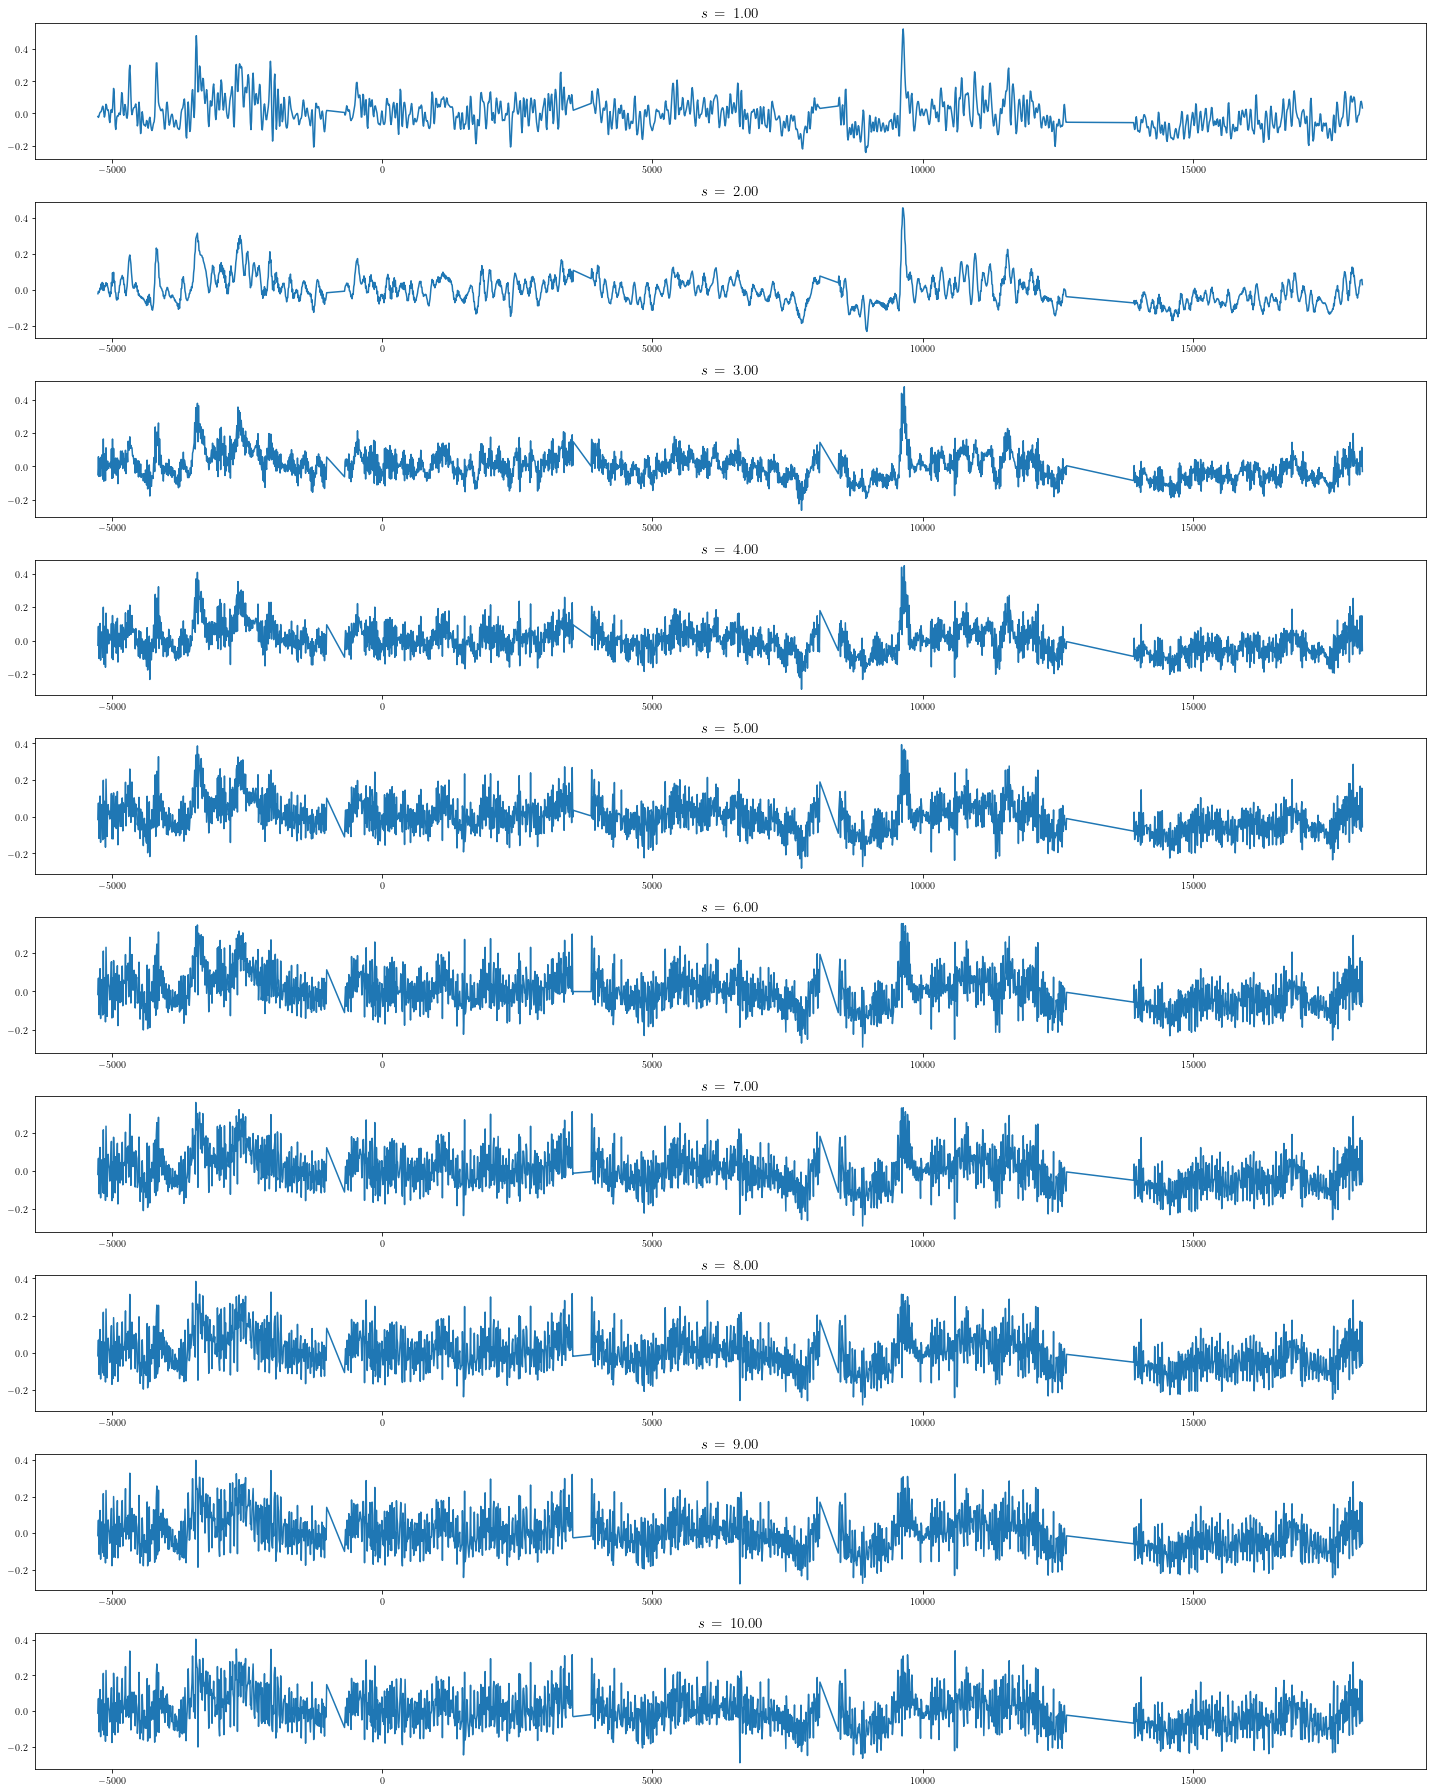

In [40]:
s_vals = np.linspace(1, 10, 10)

plt.figure(figsize=(20, 25))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=0.3, s0=s_vals[i], J=7)
    plt.subplot(10, 1, i + 1)
    plt.title('$s\,=\,{:.2f}$'.format(s_vals[i]), fontsize=15)
    plt.plot(b_band.Time, detrended_flux, label="Detrended Data")

plt.tight_layout()
plt.show()
    

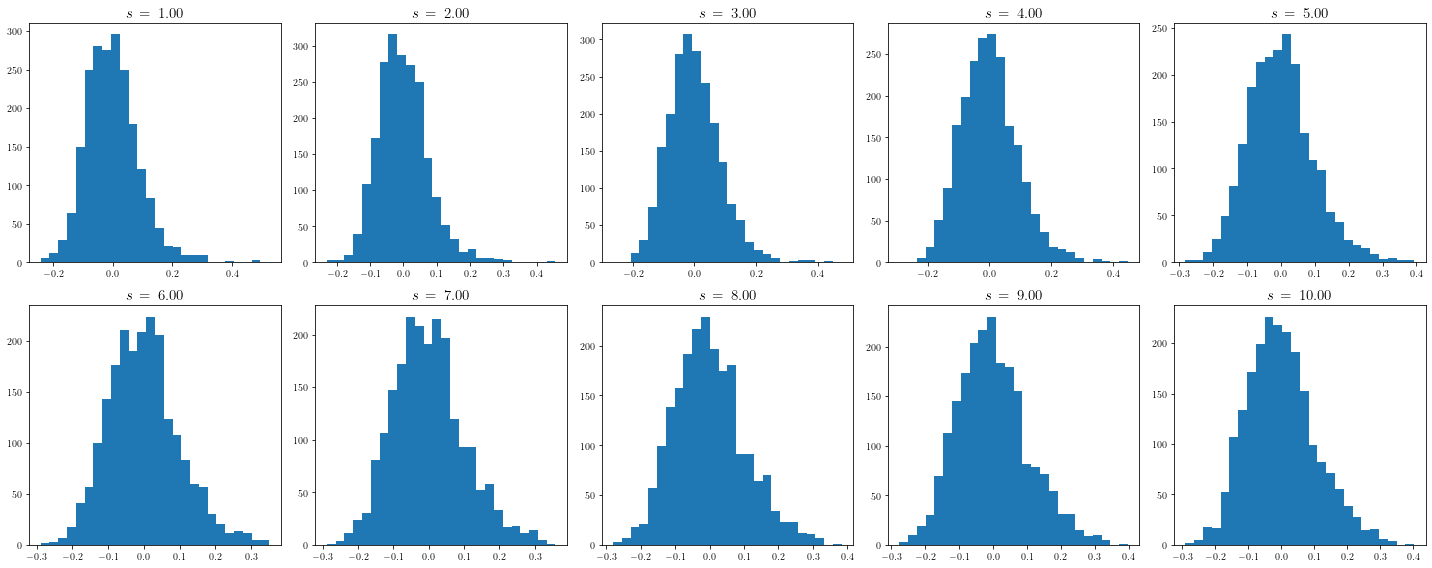

In [41]:
plt.figure(figsize=(20,8))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=0.3, s0=s_vals[i], J=7)

    plt.subplot(2, 5, i+1)
    plt.title('$s\,=\,{:.2f}$'.format(s_vals[i]), fontsize = 15)
    plt.hist(detrended_flux, tscott_bins(detrended_flux))

plt.tight_layout()
plt.show()

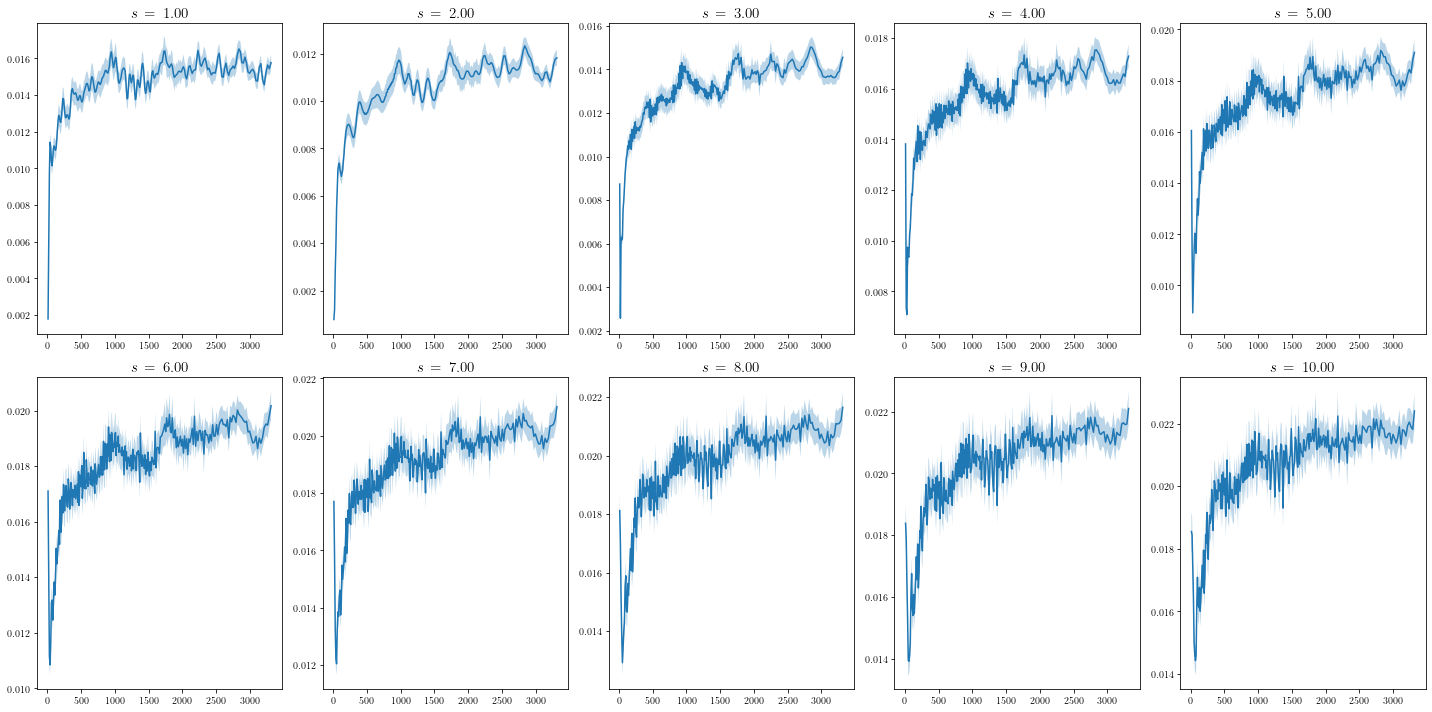

In [42]:
s_vals = np.linspace(1, 10, 10)
plt.figure(figsize=(20,10))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=0.3, s0=s_vals[i], J=7)
    bin_cent_wav, msd_wav, msd_err_wav = binned_msd(detrended_flux, b_band.Time, n_bins = 1000)

    plt.subplot(2, 5, i+1)
    plt.title('$s\,=\,{:.2f}$'.format(s_vals[i]), fontsize = 15)
    plt.plot(bin_cent_wav, msd_wav)
    plt.fill_between(bin_cent_wav, msd_wav - msd_err_wav, msd_wav + msd_err_wav, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
s_vals = np.linspace(1, 10, 19)

mu_vals = []
mu_err_vals = []
beta_vals = []
tau_vals = []

for s0 in s_vals:
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=0.3, s0=s0, J=7)
    bin_cent_wav, msd_wav, msd_err_wav = binned_msd(detrended_flux, b_band.Time, n_bins = 1000)

    def msd_theo_wavelet(t, mu, beta, tau):
        msd_theo_vals = msd_theo(t, mu, beta, tau)
        # msd_theo_vals += msd_wav[0] - msd_theo_vals[0]  
        return msd_theo_vals

    opt_params, cov_matrix = sp.optimize.curve_fit(
        msd_theo_wavelet,
        bin_cent_wav,
        msd_wav,
        sigma=msd_err_wav,
        absolute_sigma=False,
        bounds=([1e-3, 1e-3, 1e-3], [2.0, 200, 300])
    )

    param_errors = np.sqrt(np.diag(cov_matrix))
    mu_opt, beta_opt, tau_opt = opt_params
    mu_err, beta_err, tau_err = param_errors

    mu_vals.append(mu_opt)
    beta_vals.append(beta_opt)
    tau_vals.append(tau_opt)
    mu_err_vals.append(mu_err)

mu_vals = np.array(mu_vals)
beta_vals = np.array(beta_vals)
mu_err_vals = np.array(mu_err_vals)
tau_vals = np.array(tau_vals)

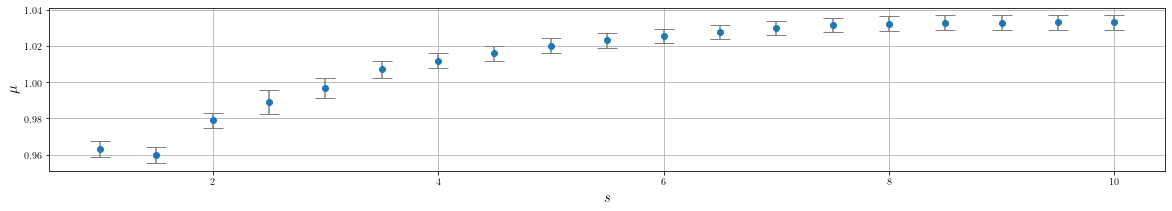

In [44]:
plt.figure(figsize = (20,3))
plt.errorbar(s_vals, mu_vals, yerr=mu_err_vals, fmt='o', ecolor='gray', capsize=10)
plt.xlabel('$s$', fontsize = 15)
plt.ylabel('$\mu$', fontsize = 15)
plt.grid(True)
plt.show()

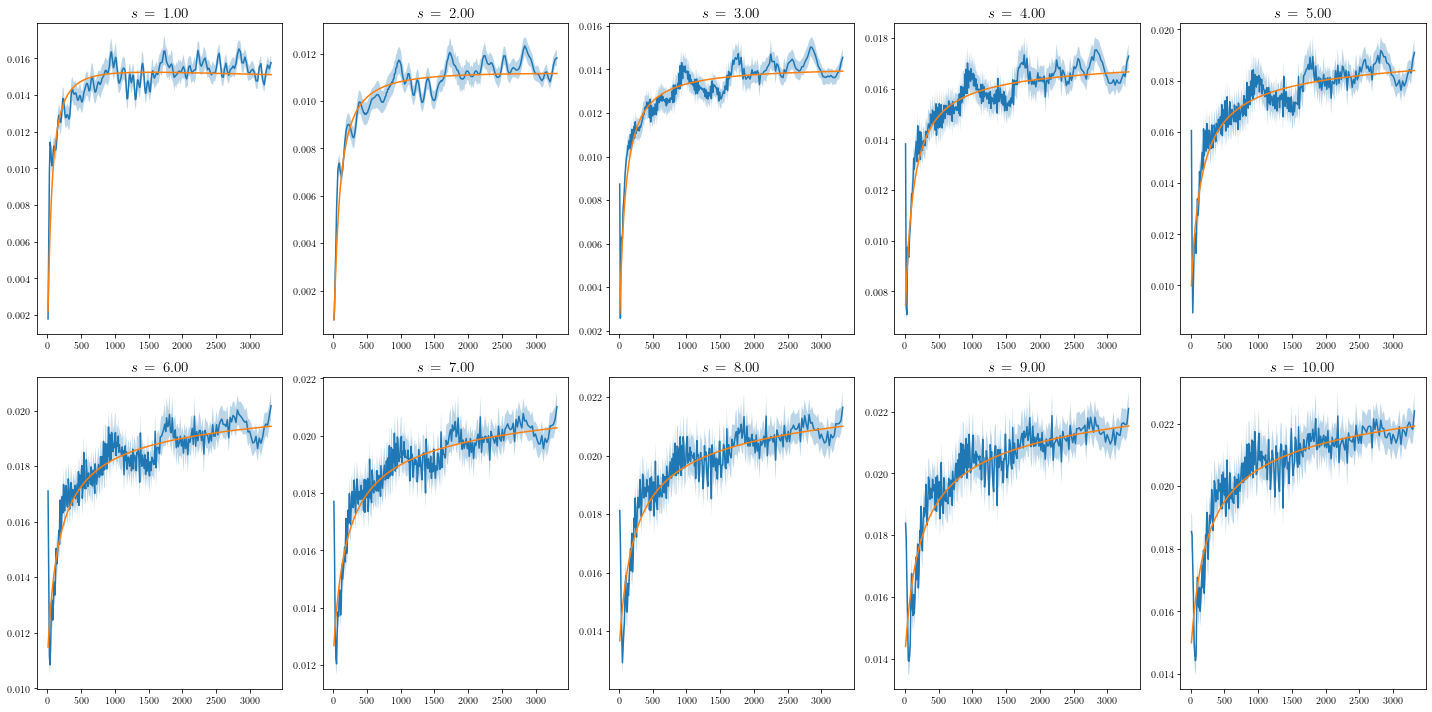

In [45]:
plt.figure(figsize=(20,10))
for i in range(10):
    detrended_flux, flux_trend = wavelet_detrend(np.array(flux), dt=1, dj=0.3, s0=s_vals[2*i], J=7)
    bin_cent_wav, msd_wav, msd_err_wav = binned_msd(detrended_flux, b_band.Time, n_bins = 1000)

    def msd_theo_wavelet(t, mu, beta, tau):
        msd_theo_vals = msd_theo(t, mu, beta, tau)
        # msd_theo_vals += abs(msd_wav[0]) - msd_theo_vals[0]  
        return msd_theo_vals

    plt.subplot(2, 5, i+1)
    plt.title('$s\,=\,{:.2f}$'.format(s_vals[2*i]), fontsize = 15)
    plt.plot(bin_cent_wav, msd_wav)
    plt.fill_between(bin_cent_wav, msd_wav - msd_err_wav, msd_wav + msd_err_wav, alpha=0.3)
    plt.plot(bin_cent_wav, msd_theo_wavelet(bin_cent_wav, mu_vals[2*i], beta_vals[2*i], tau_vals[2*i]))

plt.tight_layout()
plt.show()